In [164]:
import os
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = "5"

In [165]:
class TensorDataset(Dataset[Tuple[Tensor, ...]]):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """
    tensors: Tuple[Tensor, ...]

    def __init__(self, *tensors: Tensor) -> None:
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors), "Size mismatch between tensors"
        self.tensors = tensors

    def __getitem__(self, index):
        return index, tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

In [213]:
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        '''
            num_layers: number of layers in the neural nc_networks (EXCLUDING the input layer). If num_layers=1, this reduces to linear model.
            input_dim: dimensionality of input features
            hidden_dim: dimensionality of hidden units at ALL layers
            output_dim: number of classes for prediction
            device: which device to use
        '''

        super(MLP, self).__init__()

        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            for layer in range(num_layers - 1):
                self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for layer in range(self.num_layers - 1):
                h = F.relu(self.batch_norms[layer](self.linears[layer](h)))
            return self.linears[self.num_layers - 1](h)

In [365]:
train_size = 50000
test_size = 20000
X_1 = np.random.multivariate_normal(mean=np.array([ 1, 0]), cov=np.array([[1, 0], [0, 1]]), size=train_size)
X_0 = np.random.multivariate_normal(mean=np.array([-1, 0]), cov=np.array([[1, 0], [0, 1]]), size=train_size)
y_1 = np.ones(train_size)
y_0 = np.zeros(train_size)
p_1_1 = multivariate_normal.pdf(X_1, mean=np.array([ 1, 0]), cov=np.array([[1, 0], [0, 1]]))
p_1_0 = multivariate_normal.pdf(X_1, mean=np.array([-1, 0]), cov=np.array([[1, 0], [0, 1]]))
eta_1 = p_1_1/(p_1_1+p_1_0)
p_0_1 = multivariate_normal.pdf(X_0, mean=np.array([ 1, 0]), cov=np.array([[1, 0], [0, 1]]))
p_0_0 = multivariate_normal.pdf(X_0, mean=np.array([-1, 0]), cov=np.array([[1, 0], [0, 1]]))
eta_0 = p_0_1/(p_0_1+p_0_0)

X = np.concatenate([X_1, X_0], axis=0)
Y = np.concatenate([y_1, y_0], axis=0)
eta = np.concatenate([eta_1, eta_0], axis=0)
h_star = np.array(eta>=0.5, dtype=np.int32)

$$
P(\tilde{y} | x) = \tilde{\eta}(x) = 
\left\{
    \begin{array}{cl}
        \frac{3}{4}-\left[\eta(x)-1\right]^2 & \eta(x) >= \frac{1}{2}\\
        \frac{1}{4}+\eta(x)^2 & \eta(x) < \frac{1}{2}
    \end{array}
\right.
$$

$$
P(\tilde{y} | x) - P(y | x)= \Delta \eta(x) = 
\left\{ 
\begin{array}{cl}
-\eta(x)^2+\eta(x)-\frac{1}{4} & \eta(x) >= \frac{1}{2}\\
\eta(x)^2-\eta(x)+\frac{1}{4} & \eta(x) < \frac{1}{2}
\end{array}
\right.$$

In [366]:
# Noise function
# delta_eta = (-1/4x^2 - 3/4x + 15/16) 
# eta_tilde = -(1/4)*(x-1/2)^2+1

def calc_eta_tilde(eta):
    h_star = np.array(eta>=1/2, dtype=np.int32)
    eta_tilde = (h_star==1)*(3/4-(eta-1)**2) + (h_star==0)*(1/4+eta**2)
    return eta_tilde

eta_tilde = calc_eta_tilde(eta)
h_star_tilde = np.array(eta_tilde>=0.5, dtype=np.int32)
y_tilde = np.array([np.random.binomial(1, x, 1) for x in eta_tilde])

noise_ind = np.where(np.logical_not(y_tilde.squeeze()==h_star))[0]

Text(0.5, 1.0, 'Bayes Noisy Labels $\\tilde{h}^*(x)$')

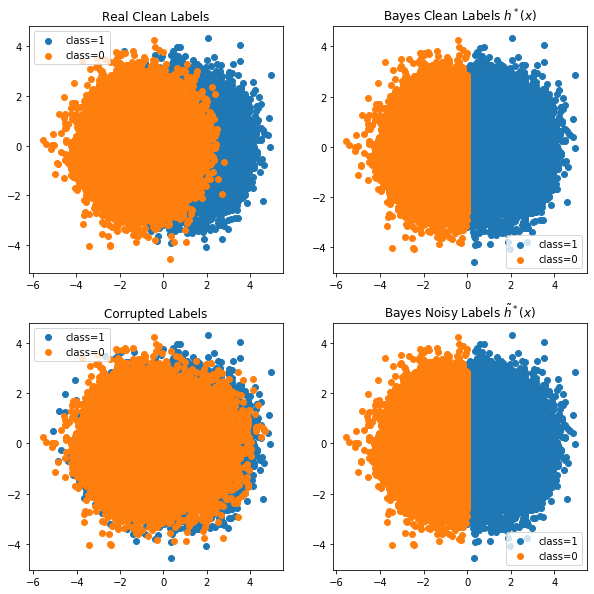

In [367]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(X_1[:, 0], X_1[:, 1], label='class=1')
plt.scatter(X_0[:, 0], X_0[:, 1], label='class=0')
plt.legend()
plt.title("Real Clean Labels")
plt.subplot(2, 2, 2)
plt.scatter(X[np.where(h_star==1), 0], X[np.where(h_star==1), 1], label='class=1')
plt.scatter(X[np.where(h_star==0), 0], X[np.where(h_star==0), 1], label='class=0')
plt.legend()
plt.title(r"Bayes Clean Labels $h^*(x)$")
plt.subplot(2, 2, 3)
plt.scatter(X[np.where(y_tilde==1), 0], X[np.where(y_tilde==1), 1], label='class=1')
plt.scatter(X[np.where(y_tilde==0), 0], X[np.where(y_tilde==0), 1], label='class=0')
plt.legend()
plt.title("Corrupted Labels")
plt.subplot(2, 2, 4)
plt.scatter(X[np.where(h_star_tilde==1), 0], X[np.where(h_star_tilde==1), 1], label='class=1')
plt.scatter(X[np.where(h_star_tilde==0), 0], X[np.where(h_star_tilde==0), 1], label='class=0')
plt.legend()
plt.title(r"Bayes Noisy Labels $\tilde{h}^*(x)$")

In [368]:
ind = np.linspace(0, (train_size+test_size)-1, (train_size+test_size)).astype(np.int32)
train_ind = np.random.choice(ind, train_size, replace=False)
test_ind = np.array([x for x in set(ind) - set(train_ind)]).astype(np.int32)

X_train = X[train_ind, :]
y_train = Y[train_ind]
y_tilde_train = y_tilde[train_ind]

X_test = X[test_ind, :]
y_tilde_test = y_tilde[test_ind]

trainset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_tilde_train).squeeze().float())
testset  = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_tilde_test).squeeze().float())
train_loader = DataLoader(trainset, batch_size=512, shuffle=True, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=512, shuffle=True, pin_memory=True) 

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device=torch.device('cpu')

cls = MLP(num_layers=1, input_dim=2, hidden_dim=5, output_dim=1)
conf_model = MLP(num_layers=3, input_dim=2+1, hidden_dim=5, output_dim=1)
# cls, conf_model = cls.to(device), conf_model.to(device)

cls_optimizer = torch.optim.Adam(cls.parameters(), lr=1e-2, weight_decay=1e-6)
num_epoch = 120
criterion = torch.nn.BCELoss()

# Fit cls
train_conf_delta = torch.zeros(len(trainset))
train_conf = torch.zeros(len(trainset))
for epoch in range(num_epoch):
    
    total_loss = 0
    total_num  = 0
    total_correct = 0
    
    for batch in enumerate(train_loader):
        
        _, batch = batch
        ind, batch, labels = batch[0], batch[1][0], batch[1][1]
        
        cls_optimizer.zero_grad()
        
        batch, labels = batch.to(device), labels.to(device)
        outputs = cls(batch)
        loss = criterion(torch.sigmoid(outputs).squeeze(), labels)
        loss.backward()
        cls_optimizer.step()
        
        total_num += len(labels)
        conf = torch.sigmoid(outputs).squeeze()
        predict = torch.tensor(conf >= 1/2).long()
        total_correct += predict.eq(labels).sum().item()
        
        train_conf[ind] = conf.detach().cpu().squeeze()
        train_conf_delta[ind] = torch.abs(predict - labels).detach().cpu()
    
    if not epoch%10:
        print(f"Loss {loss:.3f} - Acc {total_correct/total_num*100:.3f}%")

test_conf_delta  = torch.zeros(len(testset))
test_categorical = torch.zeros(len(testset))
test_conf = torch.zeros(len(testset))
for batch in enumerate(test_loader):
    _, batch = batch
    ind, batch, labels = batch[0], batch[1][0], batch[1][1]

    batch, labels = batch.to(device), labels.to(device)
    outputs = cls(batch)

    total_num += len(labels)
    conf = torch.sigmoid(outputs).squeeze()
    predict = torch.tensor(conf >= 1/2).long()
    total_correct += predict.eq(labels).sum().item()
    
    test_conf_delta[ind]  = torch.abs(predict-labels).detach().cpu()
    test_categorical[ind] = predict.detach().float().cpu()
    test_conf[ind] = conf.detach().float().cpu()
print("----------------------------------------------------------")
print(f"Loss {loss:.3f} - Acc {total_correct/total_num*100:.3f}%")     

print("# =========================================================================")
#Regress conf_model
# reg_traindataset = TensorDataset(torch.from_numpy(X_train).float(), train_conf_delta.squeeze().float())
# reg_trainloader  = DataLoader(reg_traindataset, batch_size=256, shuffle=True)
# reg_testdataset = TensorDataset(torch.from_numpy(X_test).float(), test_conf_delta.squeeze().float())
# reg_testloader  = DataLoader(reg_testdataset, batch_size=256, shuffle=True)

reg_traindataset = TensorDataset(torch.cat([torch.from_numpy(X_train).float(), torch.tensor(train_conf).view(-1, 1)], 1), 
                                 train_conf_delta.squeeze().float())
reg_trainloader  = DataLoader(reg_traindataset, batch_size=256, shuffle=True)
reg_testdataset = TensorDataset(torch.cat([torch.from_numpy(X_test).float(), torch.tensor(test_conf).view(-1, 1)], 1),  
                                test_conf_delta.squeeze().float())
reg_testloader  = DataLoader(reg_testdataset, batch_size=256, shuffle=True)

reg_optimizer = torch.optim.Adam(conf_model.parameters(), lr=1e-3, weight_decay=1e-6)
num_epoch = 120
criterion = torch.nn.MSELoss()

test_pred = torch.zeros(len(testset))
for epoch in range(num_epoch):
    for batch in enumerate(reg_trainloader):
        
        _, batch = batch
        ind, batch, labels = batch[0], batch[1][0], batch[1][1]
        
        reg_optimizer.zero_grad()
        
        batch, labels = batch.to(device), labels.to(device)
        outputs = conf_model(batch)
        loss = criterion(torch.sigmoid(outputs).squeeze(), labels)
        loss.backward()
        reg_optimizer.step()
    
    if not epoch%10:
        print(f"epoch {epoch:.3f} \t Loss {loss:.3f}")

test_conf_delta_pred = torch.zeros(len(testset))
test_pred = torch.zeros(len(testset))
for batch in enumerate(reg_testloader):
    
    _, batch = batch
    ind, batch, labels = batch[0], batch[1][0], batch[1][1]

    reg_optimizer.zero_grad()

    batch, labels = batch.to(device), labels.to(device)
    outputs = conf_model(batch)
    loss = criterion(torch.sigmoid(outputs).squeeze(), labels)

    
    test_conf_delta_pred[ind] = torch.sigmoid(outputs).squeeze().detach().cpu()
print("-------------------------------------------------------")
print(f"Loss {loss:.3f}")

/home/songzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss 0.632 - Acc 53.686%
Loss 0.618 - Acc 70.450%
Loss 0.616 - Acc 70.334%
Loss 0.587 - Acc 70.402%
Loss 0.578 - Acc 70.376%
Loss 0.607 - Acc 70.338%
Loss 0.640 - Acc 70.290%
Loss 0.611 - Acc 70.408%
Loss 0.653 - Acc 70.354%
Loss 0.653 - Acc 70.288%
Loss 0.613 - Acc 70.360%
Loss 0.601 - Acc 70.376%


/home/songzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


----------------------------------------------------------
Loss 0.639 - Acc 70.316%
# =========================================================================


/home/songzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/songzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0.000 	 Loss 0.228
epoch 10.000 	 Loss 0.224
epoch 20.000 	 Loss 0.185
epoch 30.000 	 Loss 0.187
epoch 40.000 	 Loss 0.189
epoch 50.000 	 Loss 0.190
epoch 60.000 	 Loss 0.178
epoch 70.000 	 Loss 0.173
epoch 80.000 	 Loss 0.222
epoch 90.000 	 Loss 0.168
epoch 100.000 	 Loss 0.193
epoch 110.000 	 Loss 0.195
-------------------------------------------------------
Loss 0.243


In [376]:
 # Naive
test_conf_delta_pred = np.array(test_conf_delta_pred)
select_ind = np.where(np.logical_not(test_categorical.numpy() == y_tilde_test.squeeze()))[0]
precision = len([x for x in select_ind if x in noise_ind])/len(select_ind)
recall = len([x for x in select_ind if x in noise_ind])/len(noise_ind)
print(f"precision = {precision:.3f} \t recall = {recall:.3f}")

precision = 0.291 	 recall = 0.059


In [377]:
# Confidence
test_conf = np.array(test_conf).squeeze()
select_ind = np.where(np.logical_and(((1-test_conf)**(1-y_tilde_test.squeeze()))*(test_conf**y_tilde_test.squeeze())>=0.6, 
                                 np.logical_not(test_categorical == y_tilde_test.squeeze())))[0]
precision = len([x for x in select_ind if x in noise_ind])/len(select_ind)
recall = len([x for x in select_ind if x in noise_ind])/len(noise_ind)
print(f"precision = {precision:.3f} \t recall = {recall:.3f}")

precision = 0.299 	 recall = 0.104


In [378]:
# Ours
test_conf_delta_pred = np.array(test_conf_delta_pred)
select_ind = np.where(np.logical_and(test_conf_delta_pred >= np.quantile(test_conf_delta_pred, 0.6), 
                                     np.logical_not(test_categorical == y_tilde_test.squeeze())))[0]
precision = len([x for x in select_ind if x in noise_ind])/len(select_ind)
recall = len([x for x in select_ind if x in noise_ind])/len(noise_ind)
print(f"precision = {precision:.3f} \t recall = {recall:.3f}")

precision = 0.290 	 recall = 0.078


In [379]:
print(test_conf_delta_pred[:5])
print((h_star[test_ind]-eta_tilde[test_ind])[:5])

[0.35095    0.29329768 0.26577634 0.2515621  0.24922931]
[ 0.31871145  0.29147914 -0.26446429  0.25012891  0.25031772]


In [380]:
print(np.mean((test_conf_delta_pred-np.abs((eta_tilde[test_ind] - h_star[test_ind])))**2))

0.0003826716673189418


In [381]:
eta_tilde

array([0.74764999, 0.65599774, 0.7420247 , ..., 0.25000381, 0.59059646,
       0.36198839])

In [375]:
np.abs((eta_tilde[test_ind] - h_star[test_ind]))[:100]

array([0.31871145, 0.29147914, 0.26446429, 0.25012891, 0.25031772,
       0.25856104, 0.25970757, 0.25680638, 0.4192964 , 0.34070813,
       0.2505928 , 0.25567781, 0.25004968, 0.3282006 , 0.25601589,
       0.26558714, 0.25016913, 0.25151938, 0.2503445 , 0.29737006,
       0.26376952, 0.25523897, 0.29481498, 0.2623434 , 0.25135698,
       0.25010146, 0.26839762, 0.3512027 , 0.32232731, 0.34122262,
       0.25614445, 0.3285714 , 0.40894975, 0.27158017, 0.25028937,
       0.28624113, 0.25193692, 0.29982564, 0.36115415, 0.4760521 ,
       0.28896888, 0.26090204, 0.25029097, 0.27527031, 0.27402542,
       0.33992636, 0.43396709, 0.30065729, 0.26041948, 0.25023113,
       0.25803743, 0.25425549, 0.32517383, 0.25178413, 0.27597126,
       0.25009778, 0.36410802, 0.25002926, 0.25569119, 0.42934405,
       0.25185089, 0.25067018, 0.25168423, 0.29345475, 0.41598357,
       0.26059961, 0.31044645, 0.25006184, 0.43002232, 0.40059688,
       0.31371476, 0.32865571, 0.26450697, 0.25004827, 0.28953